# Credit card fraud detection

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
data = pd.read_csv("creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

# Setting our input and target variables + resampling.

#### 1. Normalising the amount column. The amount column is not in line with the anonimised features.

In [4]:
from sklearn.preprocessing import StandardScaler

data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1)) 
#creating a new column named as normAmount which consists the normalized  amount column .
#.reshape is done to give the data as 2D input to standardscaler

data = data.drop(['Time','Amount'],axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [5]:
X =  data.drop('Class',1) # take all attribute except Target attribute in  X
y = data.Class

# Logistic regression classifier - Undersampled data

#### We are very interested in the recall score, because that is the metric that will help us try to capture the most fraudulent transactions. If you think how Accuracy, Precision and Recall work for a confusion matrix, recall would be the most interesting:

- Accuracy = (TP+TN)/total
- Precision = TP/(TP+FP)
- Recall = TP/(TP+FN)

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score,StratifiedKFold
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report 

In [7]:
from imblearn.under_sampling import RandomUnderSampler

In [8]:
# Split data into train and test set.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

In [9]:
under = RandomUnderSampler(random_state=1)
X_under,y_under = under.fit_sample(X_train,y_train)
y_under.shape

(690,)

In [10]:
y_train.value_counts()

0    199019
1       345
Name: Class, dtype: int64

## Cross validation on under sample group to find out the best parameter

### StratifiedKFold = 5, C = 0.01, penalty = l1

In [11]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
modelCV = LogisticRegression(C = 0.01, penalty = 'l1')
recall = cross_val_score(modelCV, X_under, y_under, cv=kfold, scoring='recall')
print(recall.mean())

0.9594202898550724


### StratifiedKFold = 10, C = 0.01, penalty = l1

In [12]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
modelCV = LogisticRegression(C = 0.01, penalty = 'l1')
recall = cross_val_score(modelCV, X_under, y_under, cv=kfold, scoring='recall')
print(recall.mean())

0.9449579831932773


### StratifiedKFold = 5, C = 0.01, penalty = l2

In [22]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
modelCV = LogisticRegression(C = 0.01, penalty = 'l2')
recall = cross_val_score(modelCV, X_under, y_under, cv=kfold, scoring='recall')
print(recall.mean())

0.9188405797101449


### StratifiedKFold = 10, C = 0.05, penalty = l1

In [23]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
modelCV = LogisticRegression(C = 0.05, penalty = 'l1')
recall = cross_val_score(modelCV, X_under, y_under, cv=kfold, scoring='recall')
print(recall.mean())

0.89


### StratifiedKFold = 10, C = 0.1, penalty = l1

In [24]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
modelCV = LogisticRegression(C = 0.1, penalty = 'l1')
recall = cross_val_score(modelCV, X_under, y_under, cv=kfold, scoring='recall')
print(recall.mean())

0.8929411764705882


### StratifiedKFold = 10, C = 1, penalty = l1

In [25]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
modelCV = LogisticRegression(C = 1, penalty = 'l1')
recall = cross_val_score(modelCV, X_under, y_under, cv=kfold, scoring='recall')
print(recall.mean())

0.8985714285714286


## we decide to use StratifiedKFold = 10, C = 0.01, penalty = l1

In [13]:
# recall
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
modelCV = LogisticRegression(C = 0.01, penalty = 'l1')
recall = cross_val_score(modelCV, X_under, y_under, cv=kfold, scoring='recall')
print('recall',recall.mean())

# precision
precision = cross_val_score(modelCV, X_under, y_under, cv=kfold, scoring='precision')
print('precision:', precision.mean())

# accuracy
accuracy = cross_val_score(modelCV, X_under, y_under, cv=kfold, scoring='accuracy')
print('accuracy:',accuracy.mean())


recall 0.9449579831932773
precision: 0.8419832610716474
accuracy: 0.882689075630252


In [37]:
from sklearn.metrics import recall_score,accuracy_score,precision_score
modelCV.fit(X_under, y_under)
y_pred = modelCV.predict(X_test)

In [38]:
print('Recall score: {:.2f}'.format(recall_score(y_test,y_pred)))
print('Accuracy: {:.2f}'.format(accuracy_score(y_test,y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test,y_pred)))

Recall score: 0.93
Accuracy: 0.89
Precision: 0.01


In [39]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Recall metric in the testing dataset:  0.9251700680272109


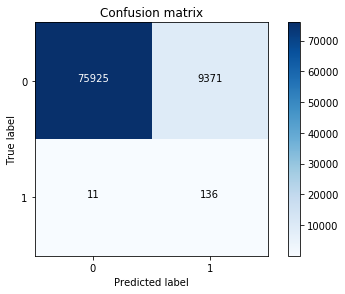

In [40]:
import matplotlib.pyplot as plt
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

# Adjust classification threshold.

thresholds:  0.1
Recall metric in the testing dataset:  1.0
Precision metric in the testing dataset:  0.0017210091904232279
Accuracy metric in the testing dataset:  0.0020481490584366184

thresholds:  0.2
Recall metric in the testing dataset:  1.0
Precision metric in the testing dataset:  0.0017241783762227591
Accuracy metric in the testing dataset:  0.003885631356576899

thresholds:  0.3
Recall metric in the testing dataset:  1.0
Precision metric in the testing dataset:  0.0017507294706127553
Accuracy metric in the testing dataset:  0.019018526971197172

thresholds:  0.4
Recall metric in the testing dataset:  0.9727891156462585
Precision metric in the testing dataset:  0.0027335461548754613
Accuracy metric in the testing dataset:  0.3893706915721592

thresholds:  0.5
Recall metric in the testing dataset:  0.9251700680272109
Precision metric in the testing dataset:  0.01430524876406858
Accuracy metric in the testing dataset:  0.8901958030499866

thresholds:  0.6
Recall metric in the te

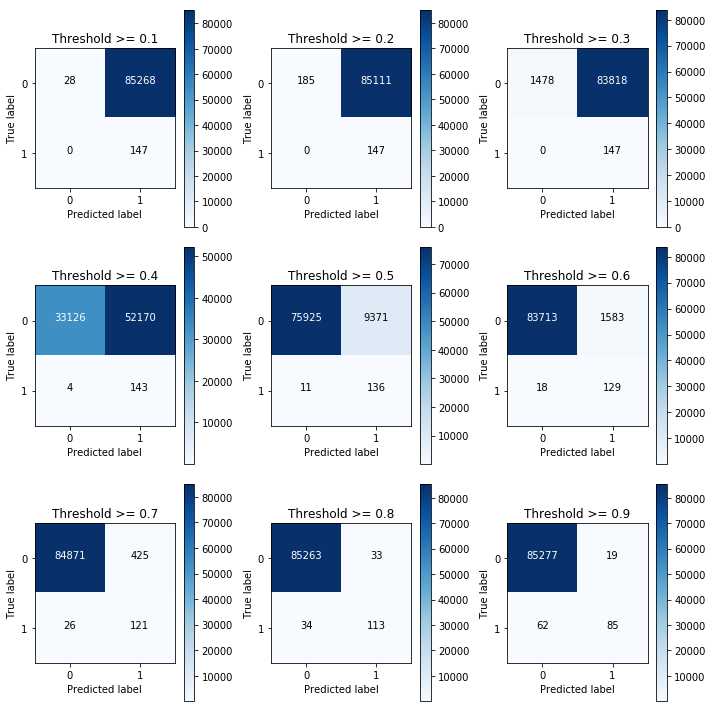

In [41]:
y_pred_proba = modelCV.predict_proba(X_test.values)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize=(10,10))

j = 1
for i in thresholds:#for every threshold we are going to print confusion matrix and recall score
    #by this we can decide at which threshold we will get the best recall score
    
    y_test_predictions_high_recall = y_pred_proba[:,1] > i
    #now creating a new list consisting of boolean expression wheather the probability is greater than the given threshold
    #So this is the prediction 
    
    
    plt.subplot(3,3,j) #as we are printing multiple confusion matrix it is good practice to place them in one cell
    #hence the dimension of each plot is going to be 3,3,j where j is the position of the confusiont matrix
    
    j += 1
    
    cnf_matrix = confusion_matrix(y_test,y_test_predictions_high_recall) 
    #creating confusion matrix on predicted and the actual target value
    np.set_printoptions(precision=2) #setting the decimal to 2

    print("thresholds: ", i)
    
    print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
    
    print("Precision metric in the testing dataset: ",cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1]))
        
    print("Accuracy metric in the testing dataset: ",(cnf_matrix[0,0]+cnf_matrix[1,1])/(cnf_matrix[0,0]+cnf_matrix[0,1]+cnf_matrix[1,1]+cnf_matrix[1,0]))
    print("")

    # Plot non-normalized confusion matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix
                          , classes=class_names
                          , title='Threshold >= %s'%i) 

## Investigate Precision-Recall curve and area under this curve.

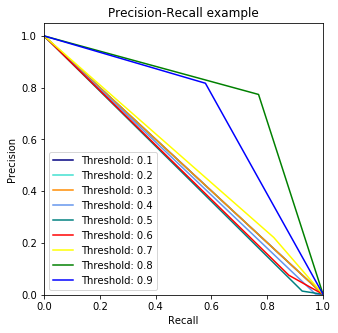

In [42]:
from itertools import cycle

y_pred_proba = modelCV.predict_proba(X_test.values)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])

plt.figure(figsize=(5,5))

j = 1
for i,color in zip(thresholds,colors):
    y_test_predictions_prob = y_pred_proba[:,1] > i
    
    precision, recall, thresholds = precision_recall_curve(y_test,y_test_predictions_prob)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color,
                 label='Threshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall example')
    plt.legend(loc="lower left")

## Conclusion: the Threshold = 0.8 return the best result; Logistic regression isn't suitable for fraud case.